## LSH

Locality-Sensitive Hashing (LSH) with random projections is a technique used to approximate nearest neighbor search efficiently. LSH is effective for high-dimensional data and uses hash functions to map similar items to the same bucket with high probability. For binary vectors, Hamming distance is commonly used to measure similarity.

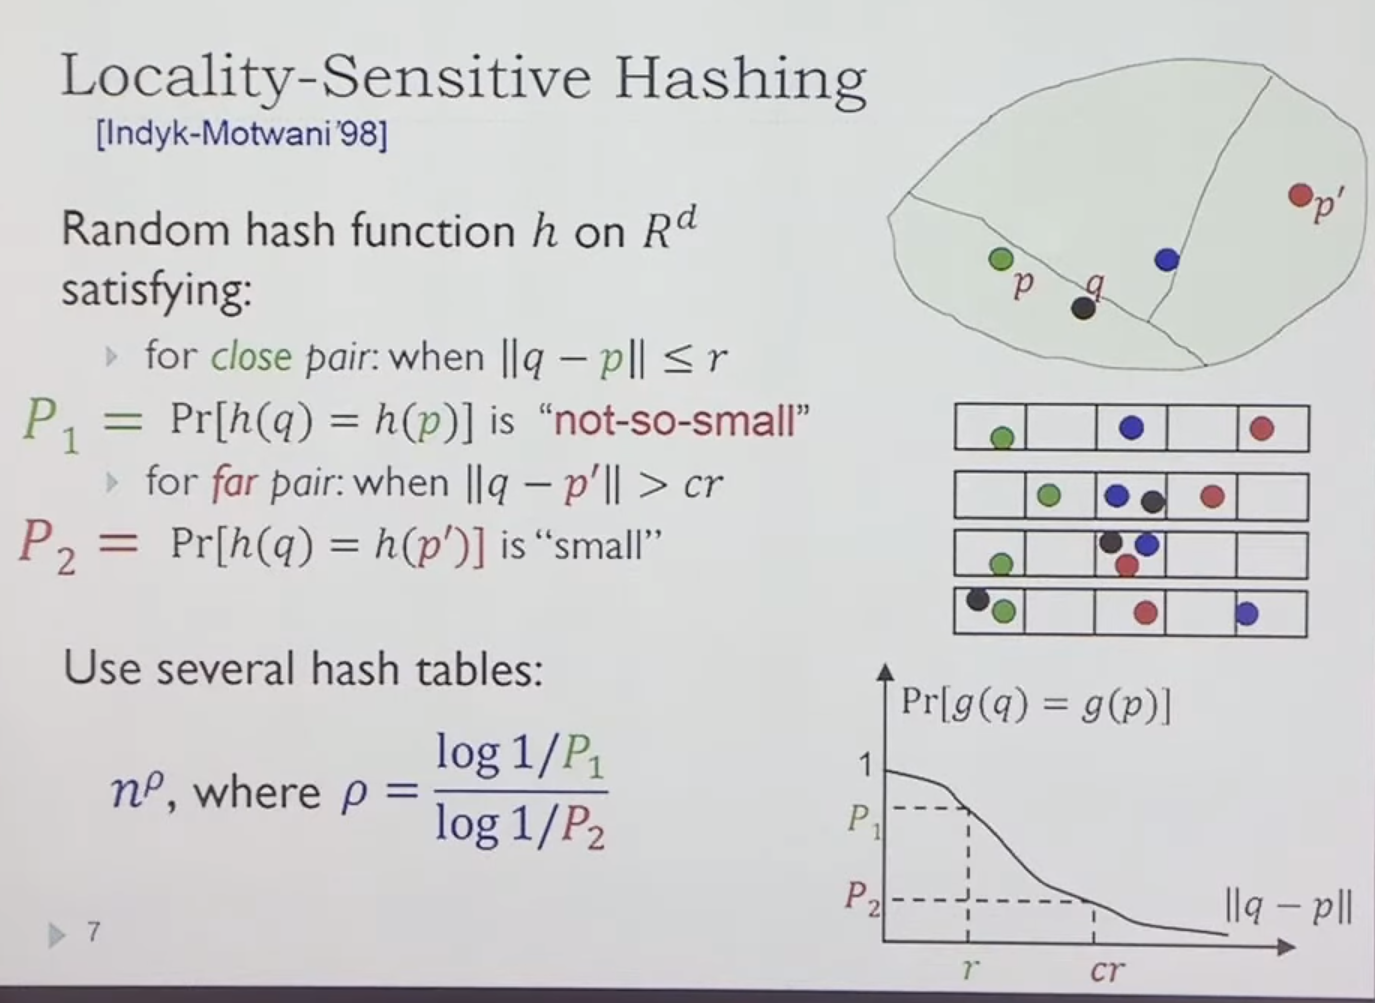


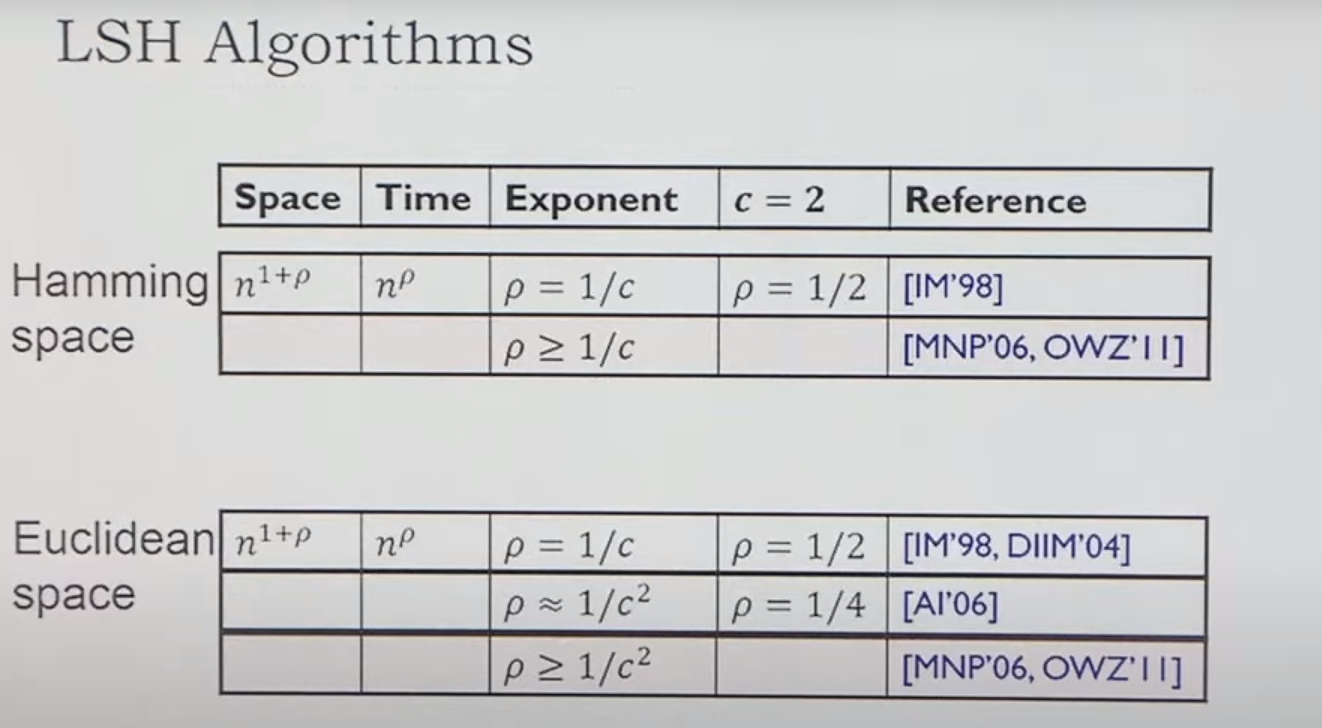

-----

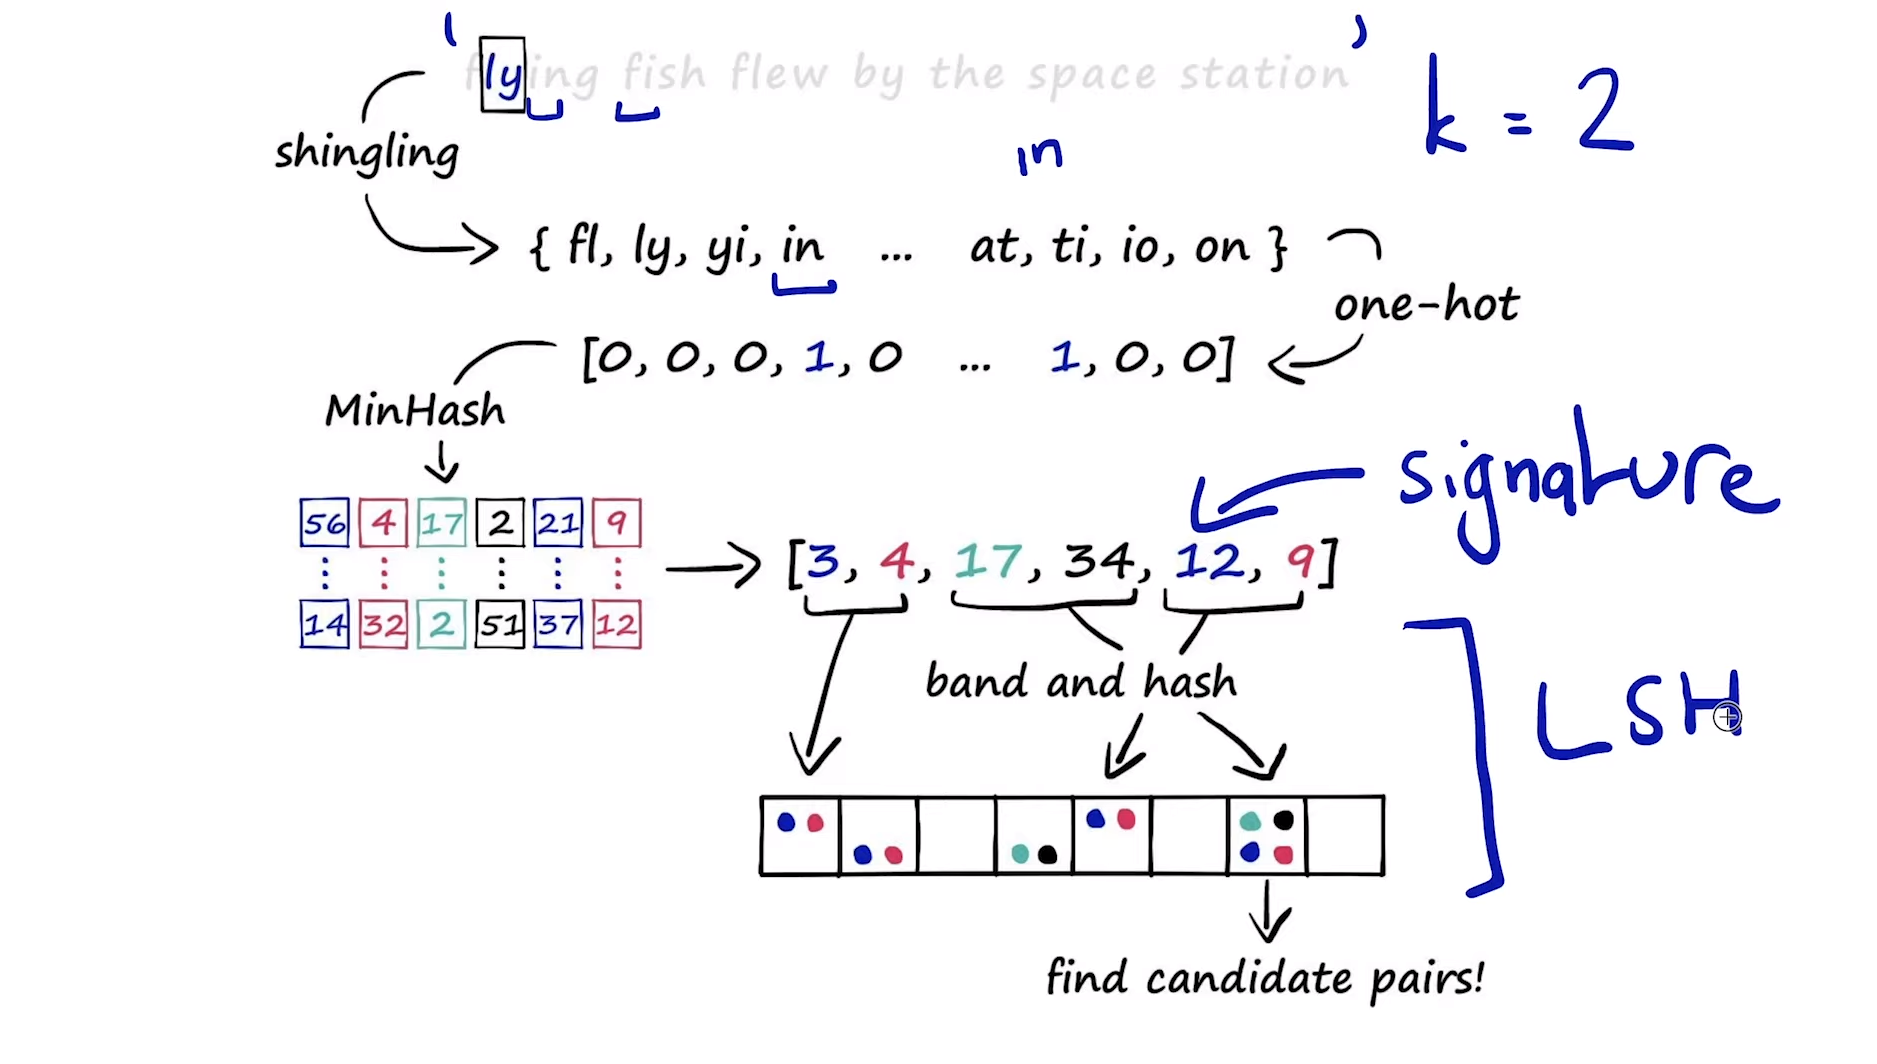

In [1]:
from random import shuffle

In [2]:
a = "1. Provide me with three similar points."
b = "2. Can you furnish three points that are alike?"
c = "3. I need three points that share similarities."

In [3]:
def shingle(text: str, k: int):
    shingle_set = []
    for i in range(len(text) -k + 1):
        shingle_set.append(text[i: i+k])
    return set(shingle_set)

In [4]:
k = 2
a_s = shingle(a, k)
b_s = shingle(b, k)
c_s = shingle(c, k)
print("Shingle a: ", a_s)

Shingle a:  {'1.', 'ee', 're', ' t', 'si', ' p', 'id', 'mi', 'ov', 'po', 'la', 'it', 'il', 'hr', 'th', ' s', 'ts', 'de', 'ar', 'h ', 'im', ' w', 'in', ' P', 'oi', 'nt', 'ro', 'me', ' m', 'vi', 'e ', 'r ', 'wi', 's.', 'Pr', '. '}


In [5]:
# create a set for vocab by taking union of other set
vocab = a_s.union(b_s).union(c_s)
print("Vocab len: ", len(vocab))

Vocab len:  73


In [6]:
# one code encoding
a_1hot =  [1 if x in a_s else 0 for x in vocab]
b_1hot =  [1 if x in b_s else 0 for x in vocab]
c_1hot =  [1 if x in c_s else 0 for x in vocab]

#### MinHash
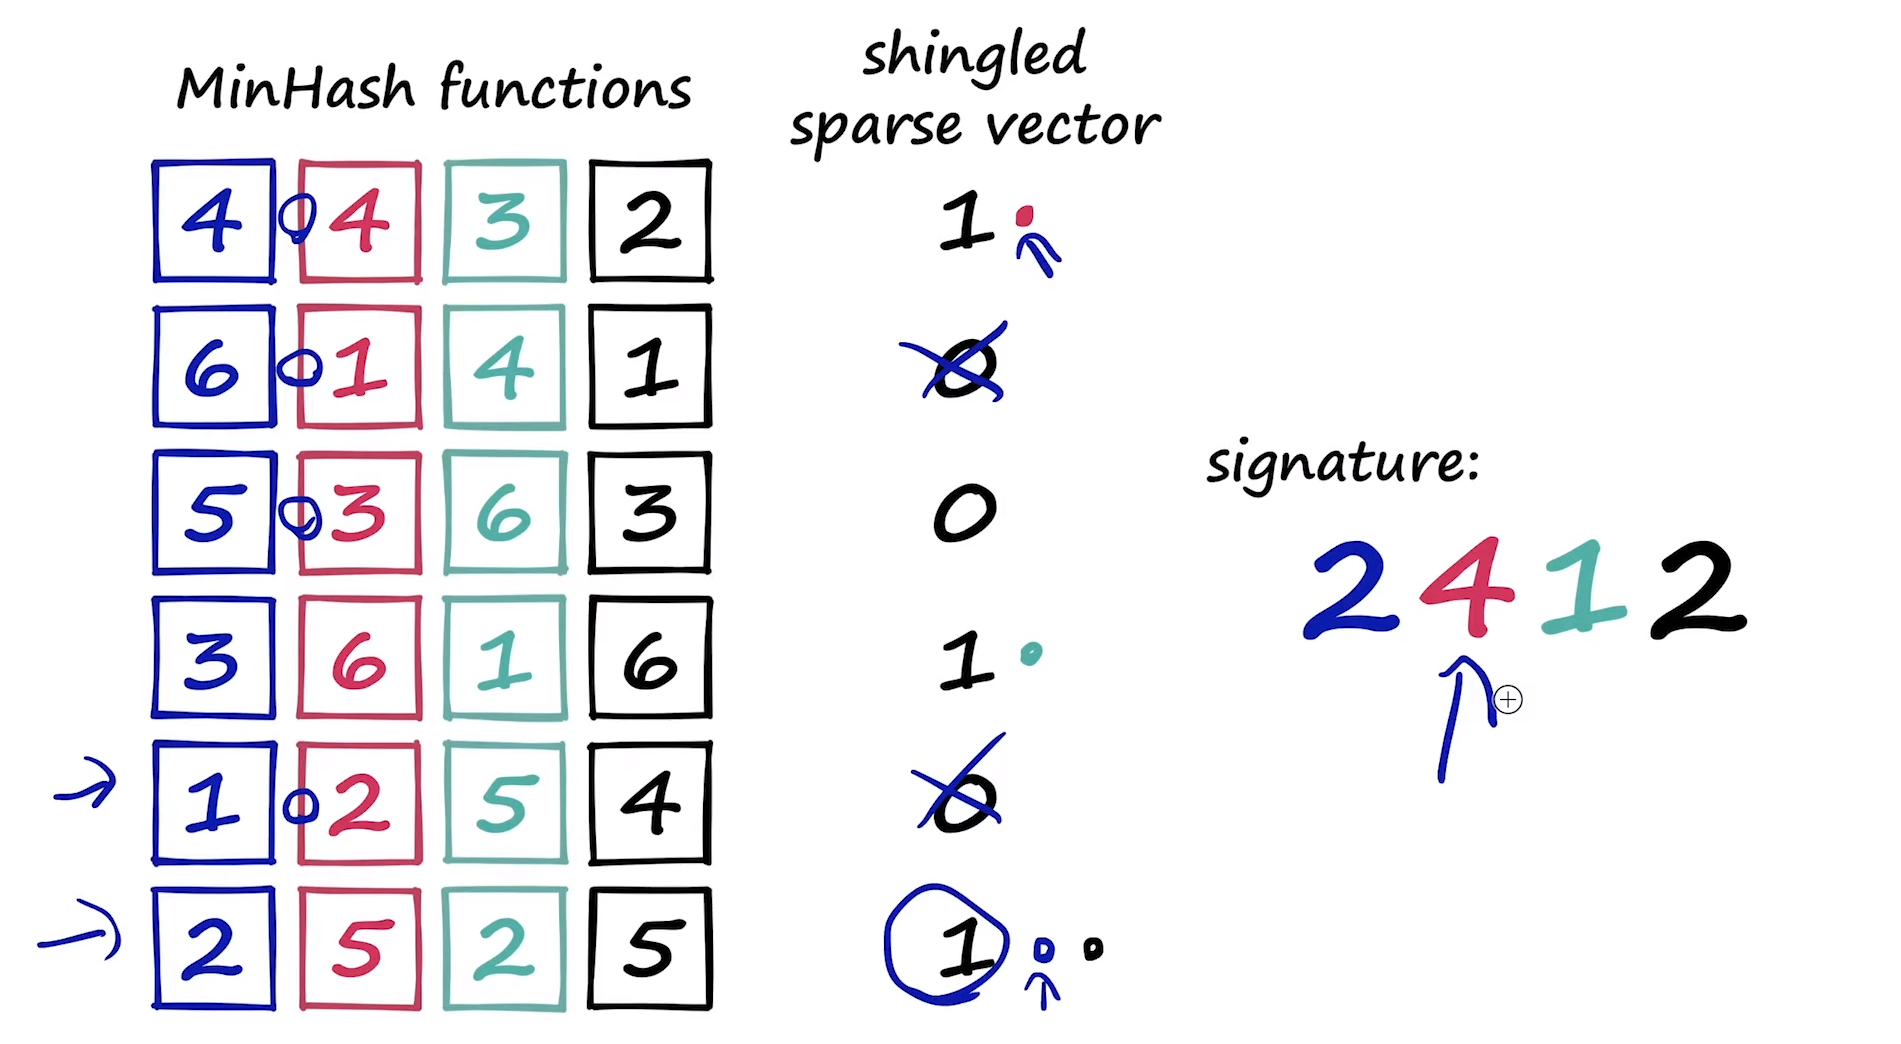

In [7]:
hash_ex = list(range(1, len(vocab) + 1))
# shuffle the hash_ex
shuffle(hash_ex)
hash_ex[:10]

[1, 71, 60, 2, 46, 59, 25, 27, 50, 47]

In [8]:
for i in range(1, len(vocab)+1):
    idx = hash_ex.index(i)
    signature_val = a_1hot[idx]
    print(f"{i} -> {idx} -> {signature_val}")
    if signature_val == 1:
        print("match")
        break

1 -> 0 -> 1
match


In [9]:
a_1hot.index(0)

1

In [10]:
def create_hash_func(size: int):
    # function for creating the hash vector/funmction
    hash_ex= list(range(1, len(vocab) + 1))
    # shuffle the list
    shuffle(hash_ex)
    return hash_ex


def build_minihash_func(vocab_size: int, nbits:int):
    # function for building minhash vectors
    hashes = []
    for _ in range(nbits):
        hashes.append(create_hash_func(vocab_size))
    return hashes

In [11]:
# create 20 minhash vectors
minhash_func = build_minihash_func(len(vocab), 20)

In [12]:
def create_signature(vector: list, minhash_func: list[list]):
    # function for creating our signature(matching)
    # len of signature is num of minhash vectors(20)
    signature = []
    for func in minhash_func:
        for i in range(1, len(vocab)+1):
            idx = func.index(i)
            signature_val = vector[idx]
            if signature_val == 1:
                signature.append(idx)
                break
    return signature

In [13]:
a_sig = create_signature(a_1hot, minhash_func=minhash_func)
b_sig = create_signature(b_1hot, minhash_func=minhash_func)
c_sig = create_signature(c_1hot, minhash_func=minhash_func)
a_sig

[38, 17, 20, 5, 38, 59, 52, 41, 53, 9, 19, 36, 62, 18, 9, 16, 7, 70, 9, 55]

In [15]:
def jaccard(x, y):
    return len(x.intersection(y)) / len(x.union(y))

jaccard(set(a_sig), set(b_sig)), jaccard(a_s, b_s)

(0.16129032258064516, 0.24193548387096775)

In [23]:
def split_vector(signature: list, b: int):
    assert len(signature) % b == 0, "Signature cannot be divided equally. Change the value of 'b'."
    r = int(len(signature) / b)
    # splitting the signature into b parts
    sub_vecs = []
    for i in range(0, len(signature), r):
        sub_vecs.append(signature[i: i+r])
    return sub_vecs

In [25]:
band_b = split_vector(b_sig, 10)
band_b

[[50, 37],
 [1, 5],
 [71, 23],
 [48, 41],
 [53, 7],
 [24, 51],
 [62, 2],
 [45, 15],
 [66, 39],
 [2, 34]]

### LSH With Random Projections

Uses **Hamming Distance**, (need low hamming distance)

In [3]:
import numpy as np
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import Binarizer

class LSH:
    def __init__(self, n_hashes, n_bits):
        self.n_hashes = n_hashes
        self.n_bits = n_bits
        self.n_features = None
        self.projections = None
        self.binarizer = Binarizer()
        self.hashes = []
        self.data = []

    def fit(self, X):
        self.n_features = X.shape[1]
        # Ensure n_bits is less than or equal to n_features
        n_bits = min(self.n_bits, self.n_features)
        self.projections = SparseRandomProjection(n_components=n_bits, random_state=42)
        # Apply random projections
        X_proj = self.projections.fit_transform(X)
        # Binarize the projected data
        X_bin = self.binarizer.fit_transform(X_proj)
        # Store the binary hashes
        self.hashes = X_bin
        self.data = X

    def query(self, X_query):
        # Apply random projections and binarize query data
        X_query_proj = self.projections.transform(X_query)
        X_query_bin = self.binarizer.transform(X_query_proj)
        
        # Compute pairwise Hamming distances
        distances = pairwise_distances(X_query_bin, self.hashes, metric='hamming')
        return distances

In [4]:
# Sample data: 10 vectors of dimension 5
np.random.seed(42)
X = np.random.rand(10, 5)

# Initialize and fit LSH
lsh = LSH(n_hashes=10, n_bits=4)  # Use a smaller number of bits to match dimensions
lsh.fit(X)

# Query with new data
X_query = np.random.rand(3, 5)
distances = lsh.query(X_query)

print("Hamming distances between query vectors and stored vectors:")
print(distances)

Hamming distances between query vectors and stored vectors:
[[0.25 0.   0.25 0.25 0.   0.25 0.   0.   0.25 0.  ]
 [0.5  0.25 0.5  0.5  0.25 0.   0.25 0.25 0.5  0.25]
 [0.25 0.   0.25 0.25 0.   0.25 0.   0.   0.25 0.  ]]
